In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import cv2
import gc
from tqdm import tqdm
from PIL import Image
from glob import glob
%matplotlib inline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [2]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df['Binary Labels'] = all_xray_df['Finding Labels'].map(lambda x: 0.0 if x == 'No Finding' else 1.0)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
91600,00022837_031.png,No Finding,31,22837,66,M,AP,3056,2544,0.139,0.139,NaN,../input/data/images_010/images/00022837_031.png,0.0
86779,00021405_001.png,No Finding,1,21405,34,F,AP,3056,2544,0.139,0.139,NaN,../input/data/images_010/images/00021405_001.png,0.0
103002,00027461_000.png,Infiltration,0,27461,62,F,PA,3056,2544,0.139,0.139,NaN,../input/data/images_011/images/00027461_000.png,1.0


In [3]:
print('Before sampling...')
label_counts = all_xray_df['Binary Labels'].value_counts()
print(label_counts)

print('After sampling...')
all_xray_df = all_xray_df.sample(20000, random_state=25)
label_counts = all_xray_df['Binary Labels'].value_counts()
print(label_counts)
all_xray_df.sample(3)

Before sampling...
0.0    60361
1.0    51759
Name: Binary Labels, dtype: int64
After sampling...
0.0    10672
1.0     9328
Name: Binary Labels, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
86931,00021456_000.png,Infiltration,0,21456,43,F,PA,2496,3056,0.139,0.139,NaN,../input/data/images_010/images/00021456_000.png,1.0
30983,00008056_004.png,No Finding,4,8056,54,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_004/images/00008056_004.png,0.0
92713,00023140_000.png,Nodule,0,23140,21,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_010/images/00023140_000.png,1.0


In [4]:
images = list(all_xray_df['path'])
labels = list(all_xray_df['Binary Labels'].map(lambda x: [x]))
train_img, val_img, train_label, val_label = train_test_split(images, labels, 
                                   test_size = 0.2, 
                                   random_state = 7,
                                   stratify = labels)
print('train:', len(train_img), '\nvalidation:', len(val_img))

train: 16000 
validation: 4000


In [6]:
class my_set(Dataset):
    def __init__(self,Data,Label,transform=None):
        self.images = Data
        self.label = Label
        self.transform = transform
        
    def __getitem__(self, index):
        label = self.label[index]
        temp = cv2.imread(self.images[index])
        temp = np.array(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
        #print(self.images[index])
        try:
          temp = (temp * 255).round().astype(np.uint8)
        except:
          print(self.images[index])
        img = Image.fromarray(temp)
        if self.transform:
          img = self.transform(img)
        label = torch.Tensor([label])
        label = label.to(torch.float)
        return img, label
        
    def __len__(self):
        return len(self.images)

my_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
])

In [7]:
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
                        nn.Linear(num_ftrs, 256),  
                        nn.ReLU(), 
                        nn.Dropout(0.2),
                        nn.Linear(256, 1),                   
                        nn.Sigmoid())
print(model)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
train = my_set(train_img, train_label, transform = my_transform)
trainloader = DataLoader(train, batch_size=16, shuffle=True, num_workers = 2)

val = my_set(val_img, val_label, transform = my_transform)
validloader = DataLoader(val, batch_size=16, shuffle=False, num_workers = 2)


valid_loss_min = np.Inf # track change in validation loss
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0002, momentum = 0.9 ,weight_decay=0.00002 )
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001, weight_decay=0.00002 )
n_epochs = 10

train_ac = []
test_ac = []
t_loss = []
v_loss = []

In [11]:
print('CUDA:',torch.version.cuda)
device = torch.device("cuda")
model = model.to(device)
print(device)
gc.collect()
torch.cuda.empty_cache()

CUDA: 11.3
cuda


In [12]:
def training_loop(model):
    for epoch in tqdm(range(1, n_epochs+1)):
        train_loss = 0.0
        valid_loss = 0.0
        print('running epoch: {}'.format(epoch))
        model.train()
        train_correct = 0
        train_total = 0
        for data, target in trainloader:
            target = target.squeeze(1)
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            train_total += target.size(0)
            predicted = (output>0.5).float()
            train_correct += (predicted == target).sum().item()
            del data
            gc.collect()
            torch.cuda.empty_cache()

        # validate the model
        model.eval()
        valid_correct = 0
        valid_total = 0
        for data, target in validloader:
            target = target.squeeze(1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_total += target.size(0)
            predicted = (output>0.5).float()
            valid_correct += (predicted == target).sum().item()
            del data
            gc.collect()
            torch.cuda.empty_cache()
        # calculate average losses
        train_loss = train_loss/len(trainloader.dataset)
        valid_loss = valid_loss/len(validloader.dataset)
        t_loss.append(train_loss)
        v_loss.append(valid_loss)
        train_ac.append(100 * train_correct / train_total)
        test_ac.append(100 * valid_correct / valid_total) 

        print('Train Loss: {}'.format(train_loss))
        print('Validation Loss: {}'.format(valid_loss))
        print('Train Accuracy: {}'.format(100 * train_correct / train_total))
        print('Validation Accuracy: {}'.format(100 * valid_correct / valid_total))

In [13]:
training_loop(model)

  0%|          | 0/10 [00:00<?, ?it/s]

running epoch: 1


 10%|█         | 1/10 [14:14<2:08:13, 854.81s/it]

Train Loss: 0.628591600805521
Validation Loss: 0.6222489941120147
Train Accuracy: 66.31875
Validation Accuracy: 67.05
running epoch: 2


 20%|██        | 2/10 [27:42<1:50:14, 826.81s/it]

Train Loss: 0.6088308282494544
Validation Loss: 0.6010102301836013
Train Accuracy: 68.025
Validation Accuracy: 68.775
running epoch: 3


 30%|███       | 3/10 [41:23<1:36:09, 824.24s/it]

Train Loss: 0.602420937538147
Validation Loss: 0.6045499135255814
Train Accuracy: 68.70625
Validation Accuracy: 69.325
running epoch: 4


 40%|████      | 4/10 [54:49<1:21:43, 817.18s/it]

Train Loss: 0.5948946846425534
Validation Loss: 0.6059752476215362
Train Accuracy: 70.06875
Validation Accuracy: 69.15
running epoch: 5


 50%|█████     | 5/10 [1:08:08<1:07:32, 810.50s/it]

Train Loss: 0.5931597957611084
Validation Loss: 0.6011446985006332
Train Accuracy: 69.7625
Validation Accuracy: 68.55
running epoch: 6


 60%|██████    | 6/10 [1:21:29<53:49, 807.36s/it]  

Train Loss: 0.5892728850245476
Validation Loss: 0.6036889230012894
Train Accuracy: 69.975
Validation Accuracy: 69.125
running epoch: 7


 70%|███████   | 7/10 [1:34:52<40:17, 805.95s/it]

Train Loss: 0.5872055784165859
Validation Loss: 0.5954630565643311
Train Accuracy: 70.3375
Validation Accuracy: 69.775
running epoch: 8


 80%|████████  | 8/10 [1:48:18<26:51, 805.96s/it]

Train Loss: 0.583399201631546
Validation Loss: 0.5960520280599594
Train Accuracy: 70.2625
Validation Accuracy: 69.575
running epoch: 9


 90%|█████████ | 9/10 [2:01:39<13:24, 804.39s/it]

Train Loss: 0.5782974089086056
Validation Loss: 0.5963124893903732
Train Accuracy: 70.5875
Validation Accuracy: 69.4
running epoch: 10


100%|██████████| 10/10 [2:14:59<00:00, 809.90s/it]

Train Loss: 0.5760091912150384
Validation Loss: 0.6070010969638825
Train Accuracy: 70.875
Validation Accuracy: 68.5


In [14]:
test_correct = 0
test_total = 0
pred_label = []
pred_for_roc_curve = []
for data, target in validloader:
    target = target.squeeze(1)
    data, target = data.to(device), target.to(device)
    out = model(data)
    predicted = (out>0.5).float()
    pred_label.extend(predicted.tolist())
    pred_for_roc_curve.extend(out.tolist())
    test_correct += (predicted == target).sum().item()
    test_total += target.size(0)
    del data
    gc.collect()
    torch.cuda.empty_cache()
print('Testing Auccracy: {}'.format((100 * test_correct / test_total)))
acu = (100 * test_correct / test_total)

Testing Auccracy: 69.375


In [18]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
model_confusion_matrix = confusion_matrix(val_label, pred_label)
model_confusion_matrix

array([[1402,  732],
       [ 493, 1373]])

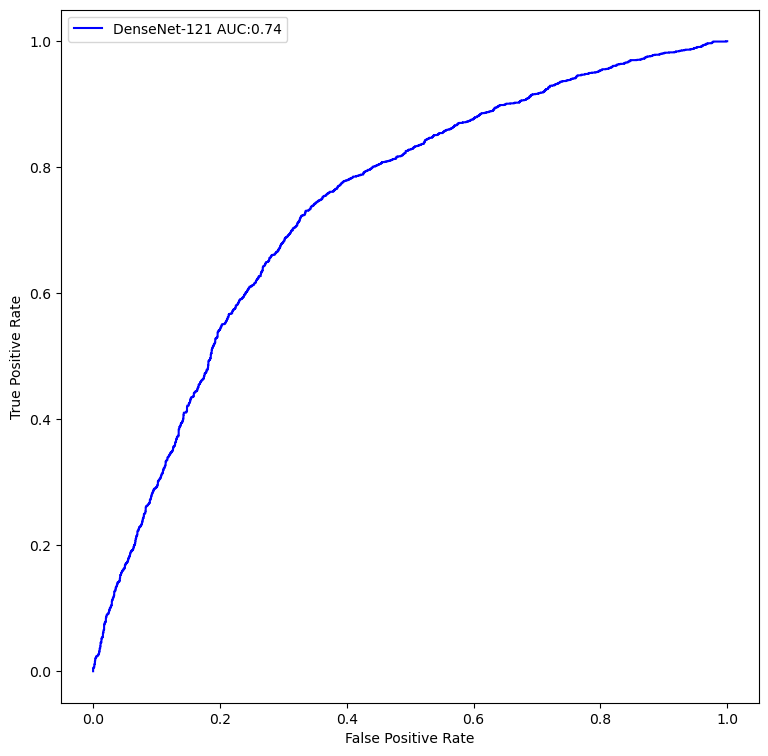

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score as acc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
fpr, tpr, thresholds = roc_curve(val_label, pred_for_roc_curve)
c_ax.plot(fpr, tpr, color='blue', label = 'DenseNet-121 AUC:%0.2f'  % (auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig("plot1.png")

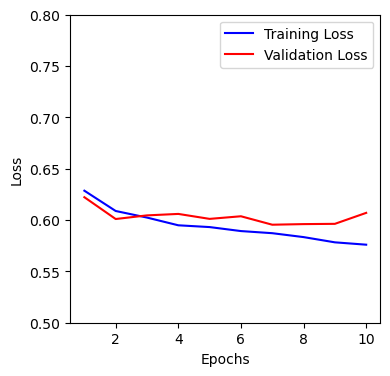

In [17]:
fig, c_ax = plt.subplots(1,1, figsize = (4, 4))
y = np.arange(1, n_epochs + 1)
c_ax.plot(y, t_loss, color='blue', label = 'Training Loss')
c_ax.plot(y, v_loss, color='red', label = 'Validation Loss')
c_ax.legend()
c_ax.set_xlabel('Epochs')
plt.ylim([0.5, 0.8])
c_ax.set_ylabel('Loss')
plt.savefig("plot2.png")